# Inference

Inference is a machine learning concept that extends on the concept of belief.  While generative models represent a random variable $x$ as a probability distribution $p(x)$, inference introduces conditional probabilistic models $p(x|u)$, i.e. the belief in $x$ given a known input $u$.  This is a function that predicts a random variable.  Prediction is typically implemented as classification for discrete random variables or regression for continuous random variables.  

In Sia, statistical prediction classes are derived from the base `sia.Inference` virtual class.  Prediction is implemented in the `predict()` method, where classification or regression is implied by the output distribution.  Inference is core to model-based estimation and control, and as such Sia includes several common builtin inference techniques summarized in the table below.

| Inference                             | Type           | Variables   | Learning     | Usage                                               |
| ------------------------------------- | -------------- | ----------- | ------------ | --------------------------------------------------- |
| Gaussian mixture model (GMM)          | Parametric     | Discrete    | Unsupervised | Uncovers structure, also functions as a distribution on continuous spaces |
| Gaussian mixture regression (GMR)     | Parametric     | Continuous  | Supervised   | Variable output noise, uses GMM structure  |
| Gaussian process regression (GPR)     | Non-parametric | Continuous  | Supervised   | Typically uses fixed output noise, good for extrapolation on Bayesian prior  |
| Gaussian process classification (GPC) | Non-parametric | Discrete    | Supervised   | GPR but with categories, uses a Dirichlet approximation for fast inference |

**References**

1. [H. G. Sung, Gaussian Mixture Regression and Classification, PhD Dissertion, Rice University, 2004.](http://www.stat.rice.edu/~hgsung/thesis.pdf)

2. [C. E. Rasmussen and C. K. I. Williams, Gaussian Process Machine Learning, MIT Press, 2006.](http://www.gaussianprocess.org/gpml/chapters/RW.pdf)

3. [D. Milios et. al., Dirichlet-based Gaussian Processes for Large-Scale Calibrated Gaussian Process Calibration, NeurIPS, 2018.](https://arxiv.org/pdf/1805.10915.pdf)

In [1]:
# Import the libSIA python bindings and numpy
import pysia as sia
import numpy as np

# Import plotting helpers
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")

# Set the generator instance seed for repeatability
generator = sia.Generator.instance()
generator.seed(10)

## Gaussian mixture model (GMM)

Sia provides a `sia.GMM` implementation for multimodal clustering and classification.  The GMM is a weighted combination of $N$ Gaussian clusters with a log likelihood defined by

$$
\log p(x) = \log \sum_i^N w_i \mathcal{N}(\mu_i,\Sigma_i)
$$

where the sum of priors (weights) $\sum_i w_i = 1$.  Classification identifies the maximum likelihood class $i$ for a given sample $x$

$$
i^* = \arg\max_i ~w_i \mathcal{N}(\mu_i, \Sigma_i).
$$

GMMs are quite versitile and have two primary uses:

1. **Clustering.**  They can be used to automatically associate data $\mathcal{D}=\{x_1, \ldots, x_N\}$ with classes $i = \{1, \ldots, N\}$.  To train them, only the data $\mathcal{D}$ and the number of classes are provided, the class association is automatically found (unsupervised learning).

2. **Generative modeling.**  GMMs are also used to represent a distribution $p(x)$.  In this case the class indices are used internally and the GMM just represents a complex distribution.  When the number of clusters $N=1$, the GMM behaves identically to the Gaussian distribution.

Because of these two use cases, `sia.GMM` is unique in that it inherits from both `sia.Distribution` and `sia.Inference`.  Sia provides a method to classify a sample by cluster using `sia.GMM.classify`.   The following example shows a mixture model for a 2D GMM with 3 clusters.  The first plot shows the distribution mean and mode, and the second plot shows samples drawn from the model with colors determined by class.

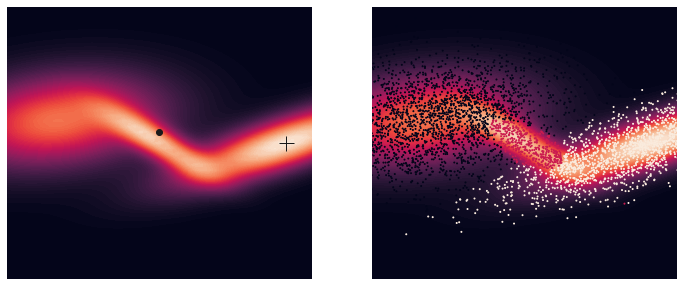

In [2]:
gaussians = [
    sia.Gaussian(mean=np.array([-2.0, 0.5]),
                 covariance=np.array([[2, 0.2], [0.2, 0.5]])),
    sia.Gaussian(mean=np.array([0.0, 0.0]),
                 covariance=np.array([[0.5, -0.3], [-0.3, 0.25]])),
    sia.Gaussian(mean=np.array([2.5, 0.0]),
                 covariance=np.array([[2.0, 0.7], [0.7, 0.4]]))
]
priors = [0.5, 0.1, 0.4]
gmm = sia.GMM(gaussians, priors)

# Draw samples from the distribution and classify
num_samples = 5000
samples = gmm.samples(num_samples)
classes = [gmm.classify(x) for x in samples]
samples = np.array(samples)

# Plot the probabilities
f, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
ax = ax.flat
sns.despine(f, left=True, bottom=True)

# Evaluate the probability using sia.Distribution.logProb(x)
x = np.linspace(-3, 3, 51)
y = np.linspace(-3, 3, 51)
xx, yy = np.meshgrid(x, y)
for i in range(2):
    
    # Helper to evaluate the probability for multiple samples
    prob = np.exp(sia.logProb2d(gmm, xx.flatten(), yy.flatten()))
    ax[i].contourf(xx, yy, np.reshape(prob, xx.shape), levels=100)
    
    # Show the mean '.' and mode '+' in the first plot
    if i == 0:
        # NOTE: The mode computation is clearly wrong
        mean = gmm.mean()
        ax[i].plot(mean[0], mean[1], ".k", ms=12)
        mode = gmm.mode()
        ax[i].plot(mode[0], mode[1], "+k", ms=15)
        
    # Plot samples and classes by color
    elif i == 1:
        ax[i].scatter(samples[:, 0], samples[:, 1], s=1, c=classes)
    
    ax[i].set_xlim((-3, 3))
    ax[i].set_ylim((-3, 3))
    ax[i].axis("off")
    i+=1

For convenience, `sia.GMM` also provides a constructor for fitting the model to sample data using the Expectation-Maximization (EM) algorithm initialized via kmeans.  If more flexilibility is needed, the `sia.GMM.fit` routine offers options for warm start initialization versus random initialization.  For functionality beyond this, a more advanced and focused Machine Learning library such as `scikit-learn` is recommended.  The following example shows fitting the data above with a new model learning from EM.

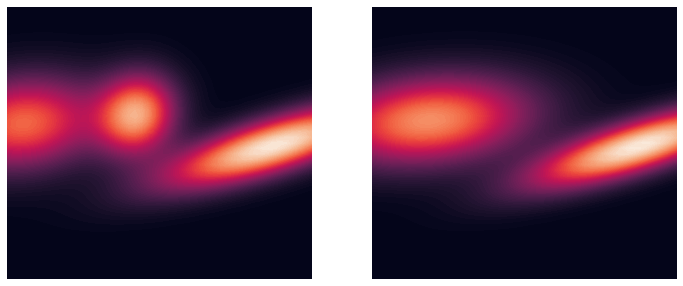

In [3]:
# Add regularization to the covariances to make sure they are positive definite
gmm_fits = [
    sia.GMM(samples.T, K=3, regularization=1e-2),
    sia.GMM(samples.T, K=2, regularization=1e-3),
]

# Plot the probabilities
f, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
ax = ax.flat
sns.despine(f, left=True, bottom=True)

# Evaluate the probability using sia.Distribution.logProb(x)
x = np.linspace(-3, 3, 51)
y = np.linspace(-3, 3, 51)
xx, yy = np.meshgrid(x, y)
for i in range(2):
    # Helper to evaluate the probability for multiple samples
    prob_fit = np.exp(sia.logProb2d(gmm_fits[i], xx.flatten(), yy.flatten()))
    ax[i].contourf(xx, yy, np.reshape(prob_fit, xx.shape), levels=100)
    ax[i].set_xlim((-3, 3))
    ax[i].set_ylim((-3, 3))
    ax[i].axis("off")
    i+=1

## Gaussian mixture regression (GMR)

`sia.GMR` implements regression that extends GMM to continuous variable conditional distributions.  It treats some of the state space as an input $x$ and some of it as an output $y$, and therefore only makes sense for distributions with 2 dimensions or more (1 axis for input, 1 for output).  With this separation, GMM is used as a generative model over the joint probability

$$
p(x, y)
$$

Gaussian mixture regression conditions on this model to predict

$$
p(y|x) = \mathcal{N}(\mu(x), \Sigma(x))
$$

where $\mu(x)$ and $\Sigma(x)$ are determined via Gaussian conditioning on the mixture.  The model is locally linear.  The covariance over the input space and mixture weights determine the contribution of each model, making it similar to a Kernel method.  GMR is particularly useful for learning models of dynamics or sensor measurements.  This example shows the GMM above now with conditioning applied.  On the left case, it is $p(x_2 | x_1)$ and the right case is $p(x_1 | x_2)$.  Note that the multiple intercepts along $y$ are blended in the right case.  This is shown to indicate that applying GMR over arbitrary inputs/outputs to a GMM does not make sense, you need to know the causality of your data to choose this appropriately.

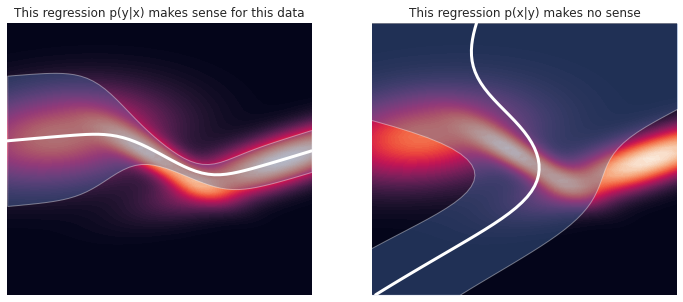

In [4]:
# Plot the probabilities
f, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
ax = ax.flat
sns.despine(f, left=True, bottom=True)

x = np.linspace(-3, 3, 51)
y = np.linspace(-3, 3, 51)

# Case 1: condition on the first variable 'x' to predict the second variable 'y'
gmr1 = sia.GMR(gmm, [0], [1])
gmr1_mu = np.zeros(len(x))
gmr1_sig = np.zeros(len(x))
for i in range(len(x)):
    gaussian = gmr1.predict(np.array([x[i]]))
    gmr1_mu[i] = gaussian.mean()[0]
    gmr1_sig[i] = gaussian.covariance()[0, 0]
ax[0].contourf(xx, yy, np.reshape(prob, xx.shape), levels=100)
ax[0].fill_between(x, gmr1_mu + 3 * gmr1_sig, gmr1_mu - 3 * gmr1_sig, alpha=0.4)
ax[0].plot(x, gmr1_mu, 'w', lw=3)
ax[0].set_xlim((-3, 3))
ax[0].set_ylim((-3, 3))
ax[0].axis("off")
ax[0].set_title("This regression p(y|x) makes sense for this data")

# Case 2: condition on the second variable 'y' to predict the first variable 'x'
gmr2 = sia.GMR(gmm, [1], [0])
gmr2_mu = np.zeros(len(y))
gmr2_sig = np.zeros(len(y))
for i in range(len(y)):
    gaussian = gmr2.predict(np.array([y[i]]))
    gmr2_mu[i] = gaussian.mean()[0]
    gmr2_sig[i] = gaussian.covariance()[0, 0]
ax[1].contourf(xx, yy, np.reshape(prob, xx.shape), levels=100)
ax[1].fill_betweenx(y, gmr2_mu + 3 * gmr2_sig, gmr2_mu - 3 * gmr2_sig,  alpha=0.4)
ax[1].plot(gmr2_mu, y, 'w', lw=3)
ax[1].set_xlim((-3, 3))
ax[1].set_ylim((-3, 3))
ax[1].axis("off")
ax[1].set_title("This regression p(x|y) makes no sense");

## Gaussian Process Regression (GPR)

`sia.GPR` implements a multi-dimensional Gaussian Process Regression model that predicts an uncorrelated output vector $y$ given an input vector $x$ for a posterior statistical function $f$

$$
p(y|x) = \mathcal{N}(\mathbb{E}[f(x)], \mathbb{V}[f(x)])
$$

Because the output vector is uncorrelated, the output variance $\mathbb{V}[f(x)]$ is a diagonal matrix.  GPR is a  hyperparametric kernel-based method.  The recommended default GP Kernel (Squared Exponential + Noise) has three hyperparameters.
- The length $l$ is a kernel smoothing term.  It control the blending between data points over the input space.
- The signal variance $\sigma_f^2$ controls the uncertainty of the prior distribution, i.e. in regions where there is no training data.  With no training data (posterior), the output variance will typically be dominated by this term.
- The noise variance $\sigma_n^2$ controls the uncertainty of the posterior distribution, i.e. by adding white noise to observation data.  With more training data (posterior), the output variance will approach this term.

Effects of these hyperparameters are shown below.  The theoretical limits of $\sigma_n$ and $\sigma_f$ are shown in dashed lines.  The blue region is the actual predicted variance.

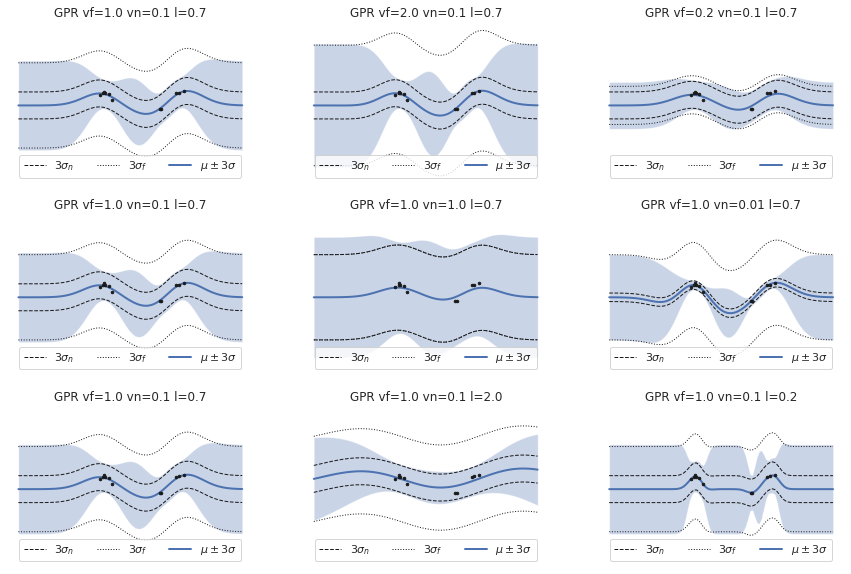

In [5]:
# Generate training data from underlying function
ntrain = 11
xtrain = np.random.uniform(0, 4, ntrain)
v = 0.1 * np.random.randn(len(xtrain))
ytrain = np.sin(2 * xtrain) + v

# Plot the raw data
f, ax = plt.subplots(nrows=3, ncols=3, figsize=(15, 10), sharex=True, sharey=True)
ax = ax.flat
sns.despine(f, left=True, bottom=True)

# Evaluate several choices of hyper parameters
varf   = [1.0, 2.0, 0.2, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
varn   = [0.1, 0.1, 0.1, 0.1, 1.0, 0.01, 0.1, 0.1, 0.1]
length = [0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 2.0, 0.2]

for i in range(len(ax)):
    # Create the GPR object
    se_kernel = sia.SEKernel(length[i], varf[i])
    noise_kernel = sia.NoiseKernel(varn[i])
    kernel = sia.CompositeKernel.add(se_kernel, noise_kernel)
    gpr = sia.GPR(input_dim=1, output_dim=1, kernel=kernel)
    gpr.setData(np.reshape(xtrain, (1, ntrain)), np.reshape(ytrain, (1, ntrain)))

    # Evaluate it
    xtest = np.linspace(-2, 6, 101)
    gpr_mu = np.zeros(len(xtest))
    gpr_sig = np.zeros(len(xtest))
    for k in range(len(xtest)):
        gaussian = gpr.predict(np.array([xtest[k]]))
        gpr_mu[k] = gaussian.mean()
        gpr_sig[k] = np.sqrt(np.diag(gaussian.covariance()))

    # Plot the belief for each axis and overlay the training data
    ax[i].fill_between(xtest, gpr_mu + 3 * gpr_sig, gpr_mu - 3 * gpr_sig,  alpha=0.3)
    ax[i].plot(xtest, gpr_mu + 3 * np.sqrt(varn[i]), '--k', lw=1, label="$3\sigma_n$")
    ax[i].plot(xtest, gpr_mu - 3 * np.sqrt(varn[i]), '--k', lw=1)
    ax[i].plot(xtest, gpr_mu + 3 * np.sqrt(varf[i]), ':k', lw=1, label="$3\sigma_f$")
    ax[i].plot(xtest, gpr_mu - 3 * np.sqrt(varf[i]), ':k', lw=1)
    ax[i].plot(xtest, gpr_mu, 'b', lw=2, label="$\mu\pm3\sigma$")
    ax[i].plot(xtrain, ytrain, '.k', ms=5)
    ax[i].legend(loc="lower center", ncol=4)
    ax[i].axis("off")
    ax[i].set_title("GPR vf={} vn={} l={}".format(varf[i], varn[i], length[i]));

**Hyperparameter optimization.** GPR provides a `GRP.train()` method to optimizer the hyperparameters using a native projected gradient descent optimizer.  If optimization with a 3rd party library is needed, GPR provides a loss function `GPR.negLogMarginalLik()` of the training data and parameter access via `GPR.hyperparameters()` that make it easy to plug in to a 3rd party optimzer, such as scipy.  Here we optimize the GPR hyperparameters using the native optimizer.

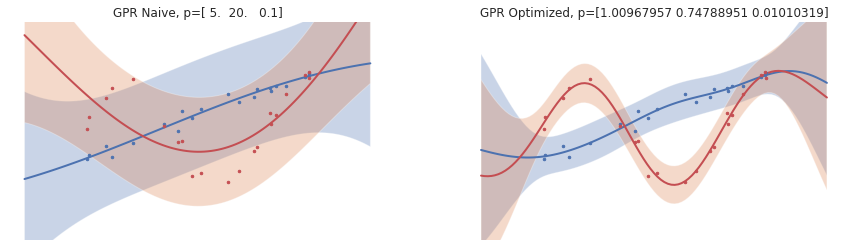

In [6]:
# Generate training data from underlying function
xtrain = np.random.uniform(0, 4, 21)
v = 0.1 * np.random.randn(2, len(xtrain))
ytrain = np.vstack((0.4 * xtrain - 0.5, np.sin(2 * xtrain))) + v

params = np.array([5., 20., 0.1])
kernel_1 = sia.SEKernel(params[0:2])
kernel_2 = sia.NoiseKernel(params[2])
kernel_3 = sia.CompositeKernel.add(kernel_1, kernel_2)
kernel_4 = sia.SEKernel(params[0:2])
kernel_5 = sia.NoiseKernel(params[2])
kernel_6 = sia.CompositeKernel.add(kernel_4, kernel_5)
gpr_naive = sia.GPR(np.array([xtrain]), ytrain, kernel=kernel_3)
gpr_optm = sia.GPR(np.array([xtrain]), ytrain, kernel=kernel_6)
gpr_optm.train()

models = {
    "Naive": gpr_naive,
    "Optimized": gpr_optm
}

# Plot the raw data
f, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
ax = ax.flat
sns.despine(f, left=True, bottom=True)

for i in range(len(models.values())):
    key = list(models.keys())[i]
    
    # Evaluate it
    xtest = np.linspace(-1, 5, 101)
    gpr_mu = np.zeros((2, len(xtest)))
    gpr_sig = np.zeros((2, len(xtest)))
    for k in range(len(xtest)):
        gaussian = models[key].predict(np.array([xtest[k]]))
        gpr_mu[:, k] = gaussian.mean()
        gpr_sig[:, k] = np.sqrt(np.diag(gaussian.covariance()))
    
    # Plot the belief for each axis and overlay the training data
    ax[i].fill_between(xtest, gpr_mu[0, :] + 3 * gpr_sig[0, :], gpr_mu[0, :] - 3 * gpr_sig[0, :],  alpha=0.3)
    ax[i].plot(xtest, gpr_mu[0, :], 'b', lw=2)
    ax[i].fill_between(xtest, gpr_mu[1, :] + 3 * gpr_sig[1, :], gpr_mu[1, :] - 3 * gpr_sig[1, :],  alpha=0.3)
    ax[i].plot(xtest, gpr_mu[1, :], 'r', lw=2)
    ax[i].plot(xtrain, ytrain[0, :], '.b', ms=5)
    ax[i].plot(xtrain, ytrain[1, :], '.r', ms=5)
    ax[i].set_ylim((-2, 2))
    ax[i].axis("off")
    ax[i].set_title("GPR {}, p={}".format(key, models[key].hyperparameters()));

## Gaussian Process Classification (GPC)

`sia.GPC` implements a multi-dimensional Gaussian Process Classification model that predicts a Dirichlet distribution $p(y|x) = \mathcal{D}ir(x)$ to describe the softmax probability of seeing a class.  The dimension of the output Dirichlet distribution is based on the max class presented in the training data.  For the default Kernel (Squared Exponential), GPR has two hyperparameters $\sigma_f^2, l$ and a concentration $\alpha$.  The signal variance $\sigma_f^2$ controls the uncertainty of the prior distribution, i.e. in regions where there is no training data.  The length $l$ is a kernel smoothing term.  The baseline concentration $1 > \alpha > 0$ controls the uncertainty of the Dirichlet prior. Effects of these hyperparameters are shown below.  The top row demonstrates $\alpha$ (`a`), middle shows $\sigma_f^2$ (`vf`), and the bottom shows $l$ (`l`).

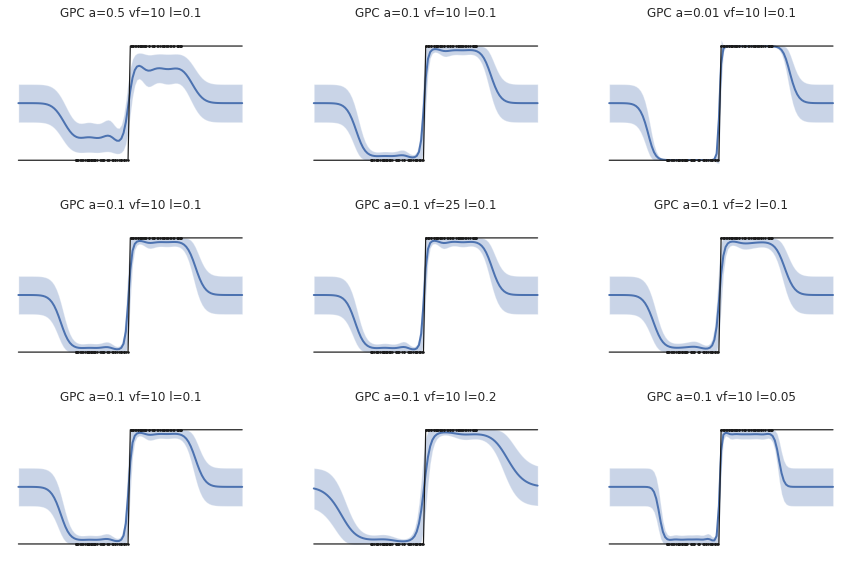

In [7]:
# Generate training data from underlying probability of a binary class
# class_prob = lambda x : -0.2 * x ** 2 + 0.6 * np.sin(6 * x) ** 2 + 0.2
class_prob = lambda x : x >= 0.5

ntrain = 100
xtrain = np.random.uniform(0, 1, ntrain)
ptrain = class_prob(xtrain)
ytrain = np.array([int(np.random.uniform(0, 1, 1) <= class_prob(x)) for x in xtrain])

# Plot the raw data
f, ax = plt.subplots(nrows=3, ncols=3, figsize=(15, 10))
ax = ax.flat
sns.despine(f, left=True, bottom=True)

# Evaluate several choices of hyper parameters
alpha  = [0.5, 0.1, 0.01, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]
varf   = [10, 10, 10, 10, 25, 2, 10, 10, 10]
length = [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.2, 0.05]

for i in range(len(ax)):
    # Create the GPC object
    kernel = sia.SEKernel(np.array([length[i], varf[i]]))
    gpc = sia.GPC(np.array([xtrain]), ytrain, kernel=kernel, alpha=alpha[i])

    # Evaluate it
    xtest = np.linspace(-0.5, 1.5, 101)
    ptest = class_prob(xtest)
    gpc_mu = np.zeros((2, len(xtest)))
    gpc_sig = np.zeros((2, len(xtest)))
    for k in range(len(xtest)):
        dirichlet = gpc.predict(np.array([xtest[k]]))
        gpc_mu[:, k] = dirichlet.mean()
        gpc_sig[:, k] = np.diag(dirichlet.covariance())
    
    # Plot the belief for each axis and overlay the training data
    ax[i].fill_between(xtest, gpc_mu[1, :] + 2 * gpc_sig[1, :], gpc_mu[1, :] - 2 * gpc_sig[1, :],  alpha=0.3)
    ax[i].plot(xtest, gpc_mu[1, :], 'b', lw=2)
    ax[i].plot(xtrain, ytrain, '.k', ms=3)
    ax[i].plot(xtest, ptest, 'k', lw=1.2)
    ax[i].set_ylim((-0.2, 1.2))
    ax[i].axis("off")
    ax[i].set_title("GPC a={} vf={} l={}".format(alpha[i], varf[i], length[i]));

**Hyperparameter optimization.** Similar to GPR, GPC provides a `GRC.train()` method to optimize the hyperparameters using a native projected gradient descent optimizer.  Note that the $\alpha$ parameter must be chosen a priori and is not optimized.

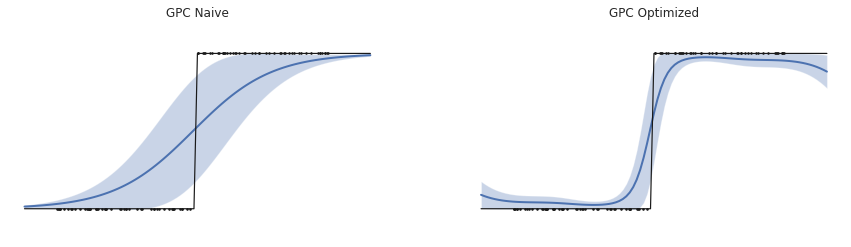

In [8]:
params = np.array([5., 20.])
kernel_a = sia.SEKernel(params)
kernel_b = sia.SEKernel(params)
gpc_naive = sia.GPC(np.array([xtrain]), ytrain, kernel=kernel_a, alpha=0.1)
gpc_optm = sia.GPC(np.array([xtrain]), ytrain, kernel=kernel_b, alpha=0.1)
gpc_optm.train()

models = {
    "Naive": gpc_naive,
    "Optimized": gpc_optm
}

# Plot the raw data
f, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
ax = ax.flat
sns.despine(f, left=True, bottom=True)

for i in range(len(models.values())):
    key = list(models.keys())[i]
    
    # Evaluate it
    xtest = np.linspace(-0.1, 1.1, 101)
    ptest = class_prob(xtest)
    gpc_mu = np.zeros((2, len(xtest)))
    gpc_sig = np.zeros((2, len(xtest)))
    for k in range(len(xtest)):
        dirichlet = models[key].predict(np.array([xtest[k]]))
        gpc_mu[:, k] = dirichlet.mean()
        gpc_sig[:, k] = np.diag(dirichlet.covariance())
    
    # Plot the belief for each axis and overlay the training data
    ax[i].fill_between(xtest, gpc_mu[1, :] + 2 * gpc_sig[1, :], gpc_mu[1, :] - 2 * gpc_sig[1, :],  alpha=0.3)
    ax[i].plot(xtest, gpc_mu[1, :], 'b', lw=2)
    ax[i].plot(xtrain, ytrain, '.k', ms=3)
    ax[i].plot(xtest, ptest, 'k', lw=1.2)
    ax[i].set_ylim((-0.2, 1.2))
    ax[i].axis("off")
    ax[i].set_title("GPC {}".format(key));